# Smoothed Disperser Attenuation study for HD160617


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [2]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [5]:
from scipy import interpolate

In [6]:
import seaborn as sns

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [10]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [11]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [12]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [13]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [14]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [15]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [16]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [17]:
home=os.getenv('HOME')

In [18]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [19]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [20]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [21]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [22]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [23]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [24]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [25]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [26]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [27]:
date="20170610"

In [28]:
idx_sel_subdir=11

In [29]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [30]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [31]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [32]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [33]:
wlshift.head()

,index,wlshift
0,135,-5.834064
1,139,-5.594220
2,140,-8.303469
3,141,8.186024
4,142,-4.141106


### path for spectra

In [34]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [35]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [36]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [37]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [38]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-11T05:27:03.156,135,778,"13,2",24,"1,018","0,667",30,HD160617,RG715,Thor300,12450,"13,6",data_10jun17,reduc_20170610_135.fits
2017-06-11T05:28:25.696,136,778,"13,4",23,"1,019","0,667",30,HD160617,RG715,HoloPhP,12450,"16,9",data_10jun17,reduc_20170610_136.fits
2017-06-11T05:29:51.205,137,778,"13,4",23,"1,019","0,802",60,HD160617,RG715,HoloPhAg,12450,"12,5",data_10jun17,reduc_20170610_137.fits
2017-06-11T05:31:43.708,138,778,"13,3",23,"1,02","0,712",60,HD160617,RG715,HoloAmAg,12450,"15,9",data_10jun17,reduc_20170610_138.fits
2017-06-11T05:34:06.396,139,778,"13,5",23,"1,874","0,712",30,HD185975,RG715,Thor300,12450,"17,4",data_10jun17,reduc_20170610_139.fits


In [39]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-11T10:18:34.256,299,778,12,23,"1,044","0,753",30,HD205905,RG715,Thor300,12450,"15,1",data_10jun17,reduc_20170610_299.fits
2017-06-11T10:19:56.704,300,778,"12,1",23,"1,046","0,753",30,HD205905,RG715,HoloPhP,12450,"15,8",data_10jun17,reduc_20170610_300.fits
2017-06-11T10:21:22.002,301,778,"12,1",23,"1,047","0,753",60,HD205905,RG715,HoloPhAg,12450,"12,8",data_10jun17,reduc_20170610_301.fits
2017-06-11T10:23:14.496,302,778,"12,1",23,"1,05","0,753",60,HD205905,RG715,HoloAmAg,12450,"15,3",data_10jun17,reduc_20170610_302.fits
2017-06-11T10:25:41.750,303,778,"12,1",23,"2,241","0,753",30,HD160617,RG715,Thor300,12450,17,data_10jun17,reduc_20170610_303.fits


### Quick view on the kind of sources

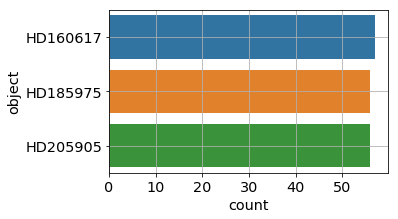

In [40]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

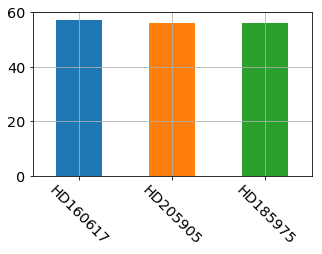

In [41]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

### Remove bad sources

- remove star **PNG336.3-05.6**

In [42]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD205905','HD185975'])]
bad_indexes=bad_obs["index"]

In [43]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-11T05:34:06.396,139,778,"13,5",23,"1,874","0,712",30,HD185975,RG715,Thor300,12450,"17,4",data_10jun17,reduc_20170610_139.fits
2017-06-11T05:35:28.909,140,778,"13,5",23,"1,873","0,62",30,HD185975,RG715,HoloPhP,12450,"13,2",data_10jun17,reduc_20170610_140.fits
2017-06-11T05:36:54.407,141,778,"13,6",22,"1,873","0,639",60,HD185975,RG715,HoloPhAg,12450,"15,2",data_10jun17,reduc_20170610_141.fits
2017-06-11T05:38:47.099,142,778,"13,6",22,"1,873","0,747",60,HD185975,RG715,HoloAmAg,12450,"16,4",data_10jun17,reduc_20170610_142.fits
2017-06-11T05:41:15.751,143,778,"13,4",22,"1,393","0,717",30,HD205905,RG715,Thor300,12450,"13,1",data_10jun17,reduc_20170610_143.fits
2017-06-11T05:42:38.303,144,778,"13,4",23,"1,387","0,717",30,HD205905,RG715,HoloPhP,12450,15,data_10jun17,reduc_20170610_144.fits
2017-06-11T05:44:02.998,145,778,"13,5",22,"1,38","0,81",60,HD205905,RG715,HoloPhAg,12450,"15,1",data_10jun17,reduc_20170610_145.fits
2017-06-11T05:45:55.408,146,778,"13,5",22,"1,371","0,708",60,HD205905,RG715,HoloAmAg,12450,"14,1",data_10jun17,reduc_20170610_146.fits
2017-06-11T05:55:26.453,151,779,"13,2",23,"1,867","0,818",30,HD185975,RG715,Thor300,12450,"15,4",data_10jun17,reduc_20170610_151.fits


In [44]:
bad_indexes=bad_obs.loc[:,"index"]

In [45]:
bad_indexes.index

Index([u'2017-06-11T05:34:06.396', u'2017-06-11T05:35:28.909',
       u'2017-06-11T05:36:54.407', u'2017-06-11T05:38:47.099',
       u'2017-06-11T05:41:15.751', u'2017-06-11T05:42:38.303',
       u'2017-06-11T05:44:02.998', u'2017-06-11T05:45:55.408',
       u'2017-06-11T05:55:26.453', u'2017-06-11T05:56:49.004',
       ...
       u'2017-06-11T10:00:01.644', u'2017-06-11T10:01:54.107',
       u'2017-06-11T10:11:24.353', u'2017-06-11T10:12:46.895',
       u'2017-06-11T10:14:13.104', u'2017-06-11T10:16:05.606',
       u'2017-06-11T10:18:34.256', u'2017-06-11T10:19:56.704',
       u'2017-06-11T10:21:22.002', u'2017-06-11T10:23:14.496'],
      dtype='object', name=u'date', length=112)

In [46]:
bad_indexes.values

array([139, 140, 141, 142, 143, 144, 145, 146, 151, 152, 153, 154, 155,
       156, 157, 158, 163, 164, 165, 166, 167, 168, 169, 170, 175, 176,
       177, 178, 179, 180, 181, 182, 187, 188, 189, 190, 191, 192, 193,
       194, 199, 200, 201, 202, 203, 204, 205, 206, 211, 212, 213, 214,
       215, 216, 217, 218, 223, 224, 225, 226, 227, 228, 229, 230, 235,
       236, 237, 238, 239, 240, 241, 242, 247, 248, 249, 250, 251, 252,
       253, 254, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273,
       274, 275, 276, 277, 278, 283, 284, 285, 286, 287, 288, 289, 290,
       295, 296, 297, 298, 299, 300, 301, 302])

### Concatenate bad obs

In [47]:
#bad_obs=pd.concat([bad_obs,bad_obs_0])

In [48]:
bad_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-11T05:34:06.396,139,778,"13,5",23,"1,874","0,712",30,HD185975,RG715,Thor300,12450,"17,4",data_10jun17,reduc_20170610_139.fits
2017-06-11T05:35:28.909,140,778,"13,5",23,"1,873","0,62",30,HD185975,RG715,HoloPhP,12450,"13,2",data_10jun17,reduc_20170610_140.fits
2017-06-11T05:36:54.407,141,778,"13,6",22,"1,873","0,639",60,HD185975,RG715,HoloPhAg,12450,"15,2",data_10jun17,reduc_20170610_141.fits
2017-06-11T05:38:47.099,142,778,"13,6",22,"1,873","0,747",60,HD185975,RG715,HoloAmAg,12450,"16,4",data_10jun17,reduc_20170610_142.fits
2017-06-11T05:41:15.751,143,778,"13,4",22,"1,393","0,717",30,HD205905,RG715,Thor300,12450,"13,1",data_10jun17,reduc_20170610_143.fits


In [49]:
bad_obs.sort_values(by="index",inplace=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
bad_indexes=bad_obs.loc[:,"index"]

In [51]:
bad_indexes.index

Index([u'2017-06-11T05:34:06.396', u'2017-06-11T05:35:28.909',
       u'2017-06-11T05:36:54.407', u'2017-06-11T05:38:47.099',
       u'2017-06-11T05:41:15.751', u'2017-06-11T05:42:38.303',
       u'2017-06-11T05:44:02.998', u'2017-06-11T05:45:55.408',
       u'2017-06-11T05:55:26.453', u'2017-06-11T05:56:49.004',
       ...
       u'2017-06-11T10:00:01.644', u'2017-06-11T10:01:54.107',
       u'2017-06-11T10:11:24.353', u'2017-06-11T10:12:46.895',
       u'2017-06-11T10:14:13.104', u'2017-06-11T10:16:05.606',
       u'2017-06-11T10:18:34.256', u'2017-06-11T10:19:56.704',
       u'2017-06-11T10:21:22.002', u'2017-06-11T10:23:14.496'],
      dtype='object', name=u'date', length=112)

In [52]:
bad_indexes.values

array([139, 140, 141, 142, 143, 144, 145, 146, 151, 152, 153, 154, 155,
       156, 157, 158, 163, 164, 165, 166, 167, 168, 169, 170, 175, 176,
       177, 178, 179, 180, 181, 182, 187, 188, 189, 190, 191, 192, 193,
       194, 199, 200, 201, 202, 203, 204, 205, 206, 211, 212, 213, 214,
       215, 216, 217, 218, 223, 224, 225, 226, 227, 228, 229, 230, 235,
       236, 237, 238, 239, 240, 241, 242, 247, 248, 249, 250, 251, 252,
       253, 254, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273,
       274, 275, 276, 277, 278, 283, 284, 285, 286, 287, 288, 289, 290,
       295, 296, 297, 298, 299, 300, 301, 302])

- keep stars **HD111980**, **HD205905**

In [53]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD160617'])]

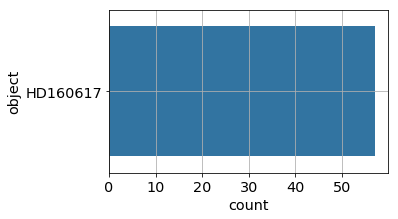

In [54]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [55]:
list_of_objects=sel2_obs['object'].values

In [56]:
list_of_objects=set(list_of_objects)

In [57]:
list_of_objects=list(list_of_objects)

In [58]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [59]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [60]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [61]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_137_spectrum.fits']

In [62]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [63]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_137_spectrum.fits']

In [64]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [65]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_137_spectrum.fits']

# Remove bad indexes

In [66]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170610_139_spectrum.fits
 remove  reduc_20170610_140_spectrum.fits
 remove  reduc_20170610_141_spectrum.fits
 remove  reduc_20170610_142_spectrum.fits
 remove  reduc_20170610_143_spectrum.fits
 remove  reduc_20170610_144_spectrum.fits
 remove  reduc_20170610_145_spectrum.fits
 remove  reduc_20170610_146_spectrum.fits
 remove  reduc_20170610_151_spectrum.fits
 remove  reduc_20170610_152_spectrum.fits
 remove  reduc_20170610_153_spectrum.fits
 remove  reduc_20170610_154_spectrum.fits
 remove  reduc_20170610_155_spectrum.fits
 remove  reduc_20170610_156_spectrum.fits
 remove  reduc_20170610_157_spectrum.fits
 remove  reduc_20170610_158_spectrum.fits
 remove  reduc_20170610_163_spectrum.fits
 remove  reduc_20170610_164_spectrum.fits
 remove  reduc_20170610_165_spectrum.fits
 remove  reduc_20170610_166_spectrum.fits
 remove  reduc_20170610_167_spectrum.fits
 remove  reduc_20170610_168_spectrum.fits
 remove  reduc_20170610_169_spectrum.fits
 remove  reduc_20170610_170_spectr

In [67]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170610_139_spectrum.fits
 remove  specsim_20170610_140_spectrum.fits
 remove  specsim_20170610_141_spectrum.fits
 remove  specsim_20170610_142_spectrum.fits
 remove  specsim_20170610_143_spectrum.fits
 remove  specsim_20170610_144_spectrum.fits
 remove  specsim_20170610_145_spectrum.fits
 remove  specsim_20170610_146_spectrum.fits
 remove  specsim_20170610_151_spectrum.fits
 remove  specsim_20170610_152_spectrum.fits
 remove  specsim_20170610_153_spectrum.fits
 remove  specsim_20170610_154_spectrum.fits
 remove  specsim_20170610_155_spectrum.fits
 remove  specsim_20170610_156_spectrum.fits
 remove  specsim_20170610_157_spectrum.fits
 remove  specsim_20170610_158_spectrum.fits
 remove  specsim_20170610_163_spectrum.fits
 remove  specsim_20170610_164_spectrum.fits
 remove  specsim_20170610_165_spectrum.fits
 remove  specsim_20170610_166_spectrum.fits
 remove  specsim_20170610_167_spectrum.fits
 remove  specsim_20170610_168_spectrum.fits
 remove  specsim_20170610_169_sp

In [68]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170610_139_spectrum.fits
 remove  specsim_20170610_140_spectrum.fits
 remove  specsim_20170610_141_spectrum.fits
 remove  specsim_20170610_142_spectrum.fits
 remove  specsim_20170610_143_spectrum.fits
 remove  specsim_20170610_144_spectrum.fits
 remove  specsim_20170610_145_spectrum.fits
 remove  specsim_20170610_146_spectrum.fits
 remove  specsim_20170610_151_spectrum.fits
 remove  specsim_20170610_152_spectrum.fits
 remove  specsim_20170610_153_spectrum.fits
 remove  specsim_20170610_154_spectrum.fits
 remove  specsim_20170610_155_spectrum.fits
 remove  specsim_20170610_156_spectrum.fits
 remove  specsim_20170610_157_spectrum.fits
 remove  specsim_20170610_158_spectrum.fits
 remove  specsim_20170610_163_spectrum.fits
 remove  specsim_20170610_164_spectrum.fits
 remove  specsim_20170610_165_spectrum.fits
 remove  specsim_20170610_166_spectrum.fits
 remove  specsim_20170610_167_spectrum.fits
 remove  specsim_20170610_168_spectrum.fits
 remove  specsim_20170610_169_sp

In [69]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170610_139_spectrum.fits
 remove  specsim_20170610_140_spectrum.fits
 remove  specsim_20170610_141_spectrum.fits
 remove  specsim_20170610_142_spectrum.fits
 remove  specsim_20170610_143_spectrum.fits
 remove  specsim_20170610_144_spectrum.fits
 remove  specsim_20170610_145_spectrum.fits
 remove  specsim_20170610_146_spectrum.fits
 remove  specsim_20170610_151_spectrum.fits
 remove  specsim_20170610_152_spectrum.fits
 remove  specsim_20170610_153_spectrum.fits
 remove  specsim_20170610_154_spectrum.fits
 remove  specsim_20170610_155_spectrum.fits
 remove  specsim_20170610_156_spectrum.fits
 remove  specsim_20170610_157_spectrum.fits
 remove  specsim_20170610_158_spectrum.fits
 remove  specsim_20170610_163_spectrum.fits
 remove  specsim_20170610_164_spectrum.fits
 remove  specsim_20170610_165_spectrum.fits
 remove  specsim_20170610_166_spectrum.fits
 remove  specsim_20170610_167_spectrum.fits
 remove  specsim_20170610_168_spectrum.fits
 remove  specsim_20170610_169_sp

# which filters

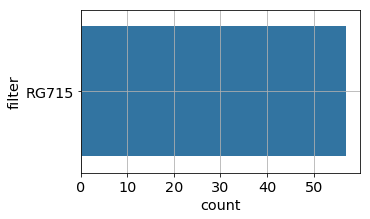

In [70]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

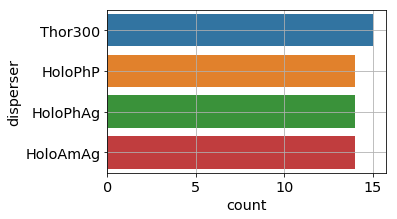

In [71]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [72]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [73]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [74]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [75]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [76]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Airmass vs Time

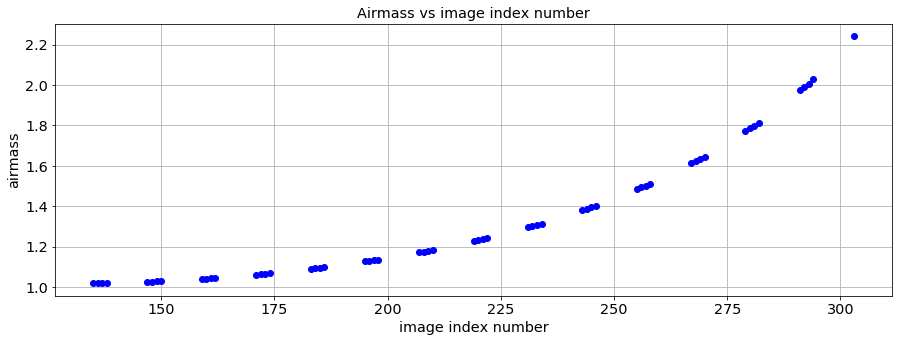

In [77]:
plt.figure(figsize=(15,5))
plt.plot(sel2_obs["index"],Convert_InFloat(sel2_obs["airmass"]),'bo')
plt.xlabel("image index number")
plt.ylabel("airmass")
plt.title('Airmass vs image index number')
plt.grid()

# Show the spectra

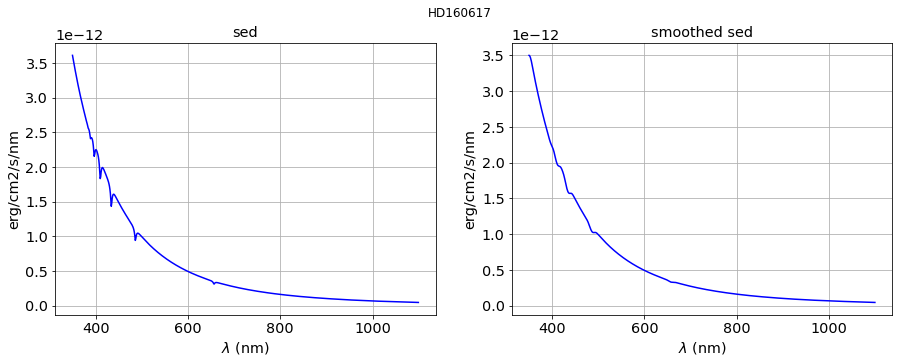

In [78]:
PlotSED(list_of_objects_str)

## Show the reconstructed spectra

In [79]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170610_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [80]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

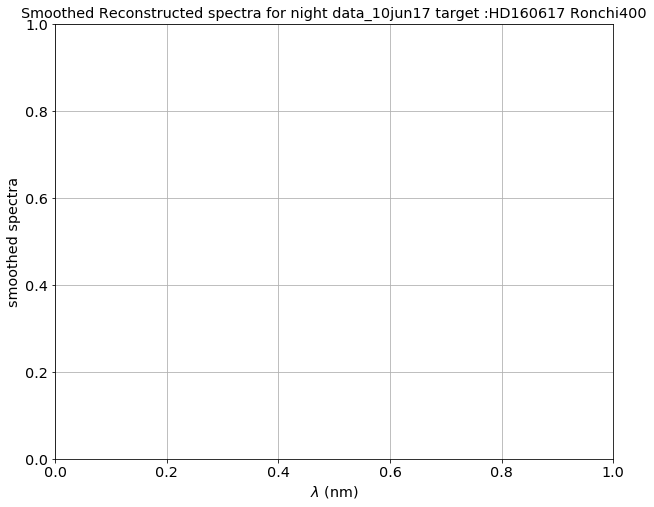

In [81]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### Thor 300

In [82]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

IndexError: index 0 is out of bounds for axis 0 with size 0

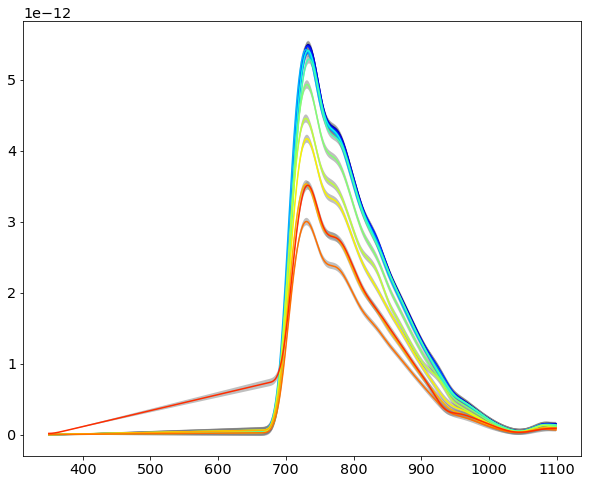

In [83]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloPhP

In [ ]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [ ]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloPhAg

In [ ]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [ ]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

### HoloAmAg

In [ ]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [ ]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=51)

## Show the simulated spectra

In [ ]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [ ]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

In [ ]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

### standard sky

In [ ]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

In [ ]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

### merra2 sky

In [ ]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

In [ ]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=51)

# Attenuation

## Ronchi 400

In [ ]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

In [ ]:
#thetitle="Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [ ]:
#PlotSpectraDataSimAttenuationSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [ ]:
#thetitle="Binned Attenuation 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [ ]:
#PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [ ]:
#thetitle="Binned Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [ ]:
#PlotSpectraDataSimAttenuationSmoothBin(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Thor300

In [ ]:
thetitle="Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=51)   

In [ ]:
thetitle="Binned Attenuation Ratio 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

## HoloPhP

In [ ]:
thetitle="Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=51)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

## HoloPhAg

In [ ]:
thetitle="Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=51)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

## HoloAmAg

In [ ]:
thetitle="Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=51)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20)   

# Simulation

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

## Simulation with ClearSky

In [ ]:
thetitle="Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=51)   

In [ ]:
thetitle="Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=51)   

In [ ]:
thetitle="Binned Attenuation Ratio 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Simulation with average Sky

In [ ]:
thetitle="Binned Attenuation Ratio 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=21,Bwidth=20) 

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 

## Simulation with MERRA2 Sky

In [ ]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

In [ ]:
PlotSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=21,Bwidth=20) 